In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import math
import csv
import re

from dotenv import load_dotenv

# Scraping

### env variables

In [2]:
load_dotenv()

BASE_PATH = os.environ['BASE_PATH']
RESULTS_PATH = os.environ['RESULTS_PATH']
RANKINGS_PATH = os.environ['RANKINGS_PATH']
SPECIALITY_RANKINGS_PATH = os.environ['SPECIALITY_RANKINGS_PATH']
TEAMS_PATH = os.environ['TEAMS_PATH']
CALENDARS_PATH = os.environ['CALENDARS_PATH']
STARTLISTS_PATH = os.environ['STARTLISTS_PATH']
RACERESULTS_PATH = os.environ['RACERESULTS_PATH']
IMG_PATH = os.environ['IMG_PATH']
RIDERSTATS_PATH = os.environ['RIDERSTATS_PATH']
RACENAMES_PATH = os.environ['RACENAMES_PATH']

# Load data

In [3]:
rider_names = list(pd.read_csv(os.path.join(BASE_PATH, 'rider_names.csv')))

# Goals

- Compute average speed for top professionals in ITT for given type of course (distance, elevation)
- select which are the top professionals
- select junior riders
- compute junior riders ITT speed and compare
- for successful ITT specialists, visualize progression from junior to pro

# Workflow

- Scrap ITT rankings at given date (now)
- Identify top 5 ITT pros
- For year in years:
    - Load their results file for given year
    - clean data
    - select ITT racedays
    - fetch race result for ITT raceday
    - get avg speed + ranking

# Top pros

- top 20 riders by PCS points

In [4]:
year = '2022'
date = '2022-04-01'

itt_ranking = pd.read_csv(os.path.join(SPECIALITY_RANKINGS_PATH, 'ITT', year, date, 'itt.csv'))
itt_ranking.Rider.iloc[:5]

0         Küng Stefan
1       Ganna Filippo
2      Asgreen Kasper
3       Roglič Primož
4    Bissegger Stefan
Name: Rider, dtype: object

In [5]:
def normalize_name(name):
    
    return '-'.join(reversed(name.split(' '))).lower()

In [6]:
year = '2022'
rider_name = normalize_name(itt_ranking.Rider[0])

df = pd.read_csv(os.path.join(RESULTS_PATH, rider_name, f'{year}.csv'), encoding='UTF-8')

In [7]:
df

,Date,Result,GC,Race,Distance,PointsPCS,PointsUCI
0,27.03,36.0,NaN,Gent-Wevelgem in Flanders Fields ME (1.UWT),248.8,5.0,10.0
1,25.03,3.0,NaN,E3 Saxo Bank Classic (1.UWT),203.9,110.0,260.0
2,06.03 » 13.03,NaN,NaN,Paris - Nice (2.UWT),NaN,NaN,NaN
3,NaN,10.0,NaN,Points classification,NaN,NaN,NaN
4,NaN,21.0,NaN,General classification,NaN,18.0,20.0
5,13.03,6.0,NaN,Stage 8 - Nice › Nice,115.6,7.0,NaN
6,12.03,38.0,33.0,Stage 7 - Nice › Col de Turini,155.2,NaN,NaN
7,11.03,66.0,32.0,Stage 6 - Courthézon › Aubagne,213.6,NaN,NaN
8,10.03,49.0,26.0,Stage 5 - Saint-Just-Saint-Rambert › Saint-Sau...,188.8,NaN,NaN
9,09.03,4.0,24.0,Stage 4 (ITT) - Domérat › Montluçon,13.4,13.0,NaN


### Clean data

In [8]:
import sys
sys.path.insert(1, '../scripts')
from data_prep_utils import *

In [9]:
df = clean_data(df, rider_name, year, save=False)

### Select ITTs

In [10]:
df[df.Race.str.contains('ITT|Chrono des Nations')]

,FromDate,Result,GC,Race,Distance,PointsPCS,PointsUCI,Type,ToDate,RaceName,Circuit
9,2022-03-09,4,24.0,Stage 4 (ITT) - Domérat › Montluçon,13.4,13.0,NaN,StageRace,2022-03-09,Paris - Nice (2.UWT),2.UWT
18,2022-02-19,2,5.0,Stage 4 (ITT) - Vila Real de Santo António › T...,32.2,18.0,10.0,StageRace,2022-02-19,Volta ao Algarve em Bicicleta (2.Pro),2.Pro


- DL data for 2022
- in data_prep.ipynb: add col for circuit

# Load race results

In [17]:
def getStageNumber(race):
    
    if 'prologue' in 
    
    try:
        
        stage = 'stage_' + re.search('Stage (\d*)', race.Race).group(1)
        
        return stage
        
    except AttributeError as e:
        
        stage = 'race_results'
        
        return stage

In [23]:
mappings = {'1.UWT': 'uci_wt',
            '2.UWT': 'uci_wt',
            '1.Pro': 'uci_pro_series',
            '2.Pro': 'uci_pro_series',
            '1.1': 'europe_tour',
            'WC': 'uci_world_championships',
            'CC': 'europe_tour',
            'Olympics': 'olympic_games',
            'NC': 'europe_tour'}

### ***PROLOGUES WITH NO (ITT) IN RACENAME NOT INCLUDED

In [60]:
res = []

for year in ['2022', '2021', '2020']:
    
    df = pd.read_csv(os.path.join(RESULTS_PATH, rider_name, f'{year}.csv'), encoding='UTF-8')
    df = clean_data(df, rider_name, year, save=False)
    itt_races = df[df.Race.str.contains('ITT|Chrono des Nations')]

    for race in itt_races.iterrows():

        circuit = race[1].Circuit
        racename = race[1].RaceName
        racename_mappings = pd.read_csv(os.path.join(RACENAMES_PATH, year, mappings[circuit], 'racename_mappings.csv'))
        race_url = racename_mappings[racename_mappings.RaceName == racename.split(' (')[0]].RaceURL.iloc[0]
        #stage = re.search('Stage (\d*)', race[1].Race).group(1)
        stage = getStageNumber(race[1])
        
        df_stage = pd.read_csv(os.path.join(RACERESULTS_PATH, mappings[circuit], race_url, year, f'{stage}.csv'))
        #print(df_stage.loc[race[1].Result-1][['Rnk', 'Avg']])
    
        res.append((race[1].FromDate,
                    race[1].Race,
                    race[1].RaceName,
                    df_stage.loc[race[1].Result-1]['Rnk'],
                    df_stage.loc[race[1].Result-1]['Avg']))

FileNotFoundError: [Errno 2] No such file or directory: '../data/pcs-scraping/race_results/uci_wt/benelux-tour/2020/stage_4.csv'

In [42]:
import matplotlib.pyplot as plt

In [47]:
df_res = pd.DataFrame(res, columns=['Date', 'Race', 'RaceName', 'Rnk', 'Avg'])
df_res

,Date,Race,RaceName,Rnk,Avg
0,2022-03-09,Stage 4 (ITT) - Domérat › Montluçon,Paris - Nice (2.UWT),4,48.727
1,2022-02-19,Stage 4 (ITT) - Vila Real de Santo António › T...,Volta ao Algarve em Bicicleta (2.Pro),2,49.815
2,2021-10-17,Chrono des Nations (1.1),Chrono des Nations (1.1),1,51.561
3,2021-09-19,World Championships - ITT (WC),World Championships - ITT (WC),5,53.129
4,2021-09-09,European Continental Championships - ITT (CC),European Continental Championships - ITT (CC),1,54.894
5,2021-08-31,Stage 2 (ITT) - Lelystad › Lelystad,Benelux Tour (2.UWT),3,53.422
6,2021-07-28,Olympic Games - ITT (Olympics),Olympic Games - ITT (Olympics),4,47.245
7,2021-07-17,Stage 20 (ITT) - Libourne › Saint-Émilion,Tour de France (2.UWT),4,50.607
8,2021-06-30,Stage 5 (ITT) - Changé › Laval Espace Mayenne,Tour de France (2.UWT),2,50.500
9,2021-06-16,National Championships Switzerland - ITT (NC),National Championships Switzerland - ITT (NC),1,49.023


<AxesSubplot:xlabel='Date'>

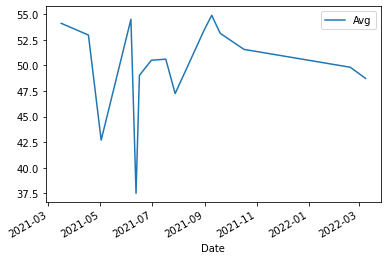

In [59]:
df_res[['Date', 'Avg']].sort_values('Date').plot(x='Date', y='Avg')